In [1]:
!pip install yfinance prophet plotly statsmodels --quiet
!pip install tensorflow --quiet


In [2]:
import yfinance as yf
import pandas as pd

# Select your stock ticker (change if needed)
ticker = 'AAPL'  # you can change this to 'TSLA', 'GOOGL', etc.

# Download 5 years of data
data = yf.download(ticker, start='2019-01-01', end='2024-12-31')

# Reset index and show sample
data.reset_index(inplace=True)
data.head()


/tmp/ipython-input-2-2131298432.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2019-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Price        Date      Close       High        Low       Open     Volume
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL
0      2019-01-02  37.617855  37.839391  36.738866  36.896084  148158800
1      2019-01-03  33.870838  34.711713  33.825578  34.297229  365248800
2      2019-01-04  35.316757  35.385840  34.254350  34.428241  234428400
3      2019-01-07  35.238152  35.452541  34.754589  35.421573  219111200
4      2019-01-08  35.909897  36.164781  35.378693  35.626428  164101200

In [3]:
data.to_csv('stock_data.csv', index=False)


In [4]:
# Check for null values
print("Null values:\n", data.isnull().sum())

# Drop rows with nulls (if any)
data.dropna(inplace=True)

# Confirm data types
print("\nData types:\n", data.dtypes)

# Convert 'Date' to datetime format (if not already)
data['Date'] = pd.to_datetime(data['Date'])


Null values:
 Price   Ticker
Date              0
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Data types:
 Price   Ticker
Date              datetime64[ns]
Close   AAPL             float64
High    AAPL             float64
Low     AAPL             float64
Open    AAPL             float64
Volume  AAPL               int64
dtype: object


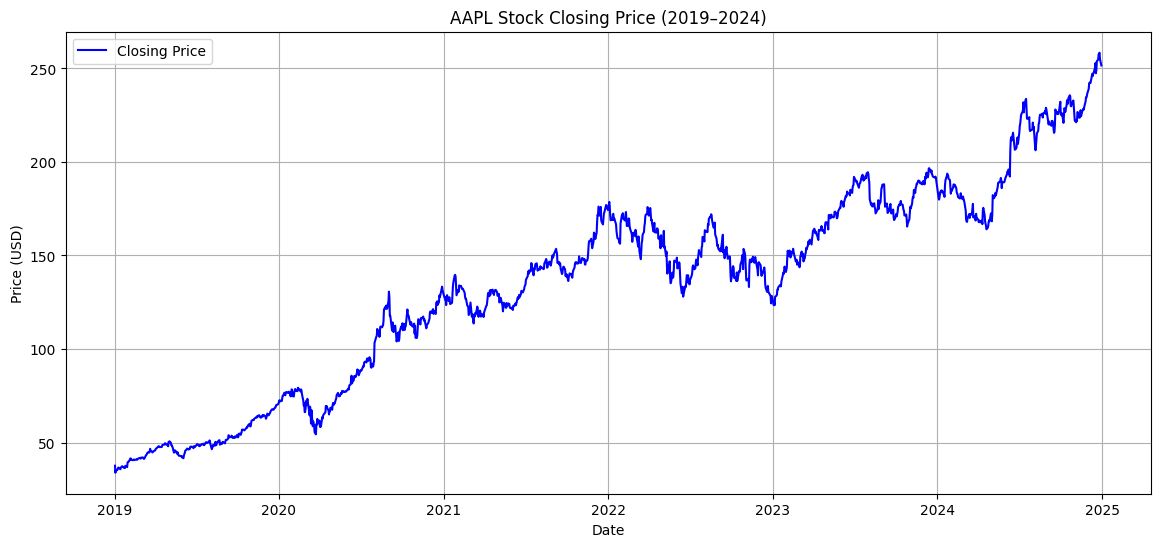

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
plt.title('AAPL Stock Closing Price (2019–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


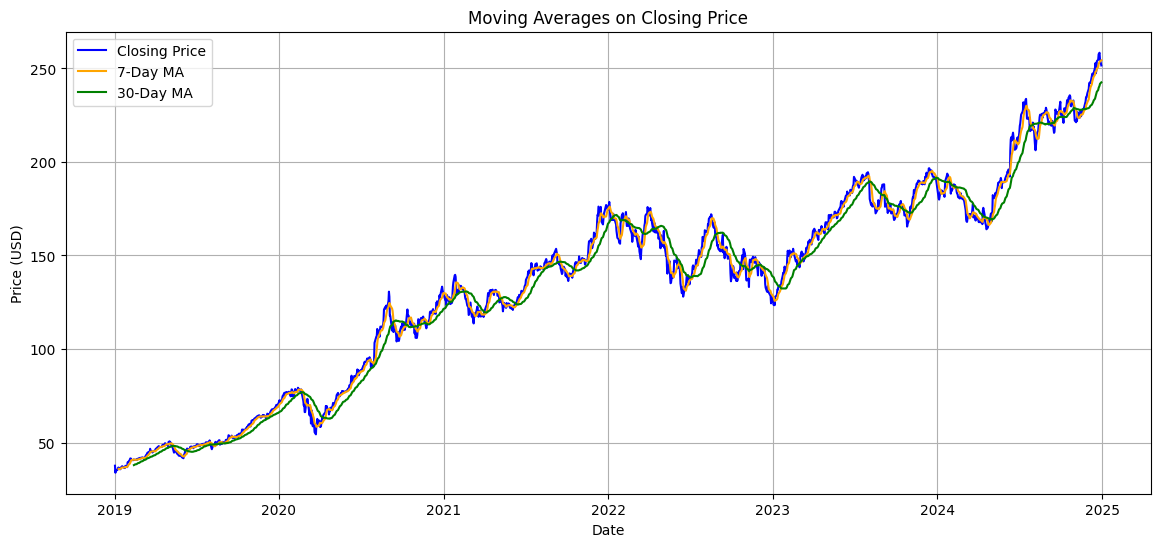

In [6]:
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
plt.plot(data['Date'], data['MA7'], label='7-Day MA', color='orange')
plt.plot(data['Date'], data['MA30'], label='30-Day MA', color='green')
plt.title('Moving Averages on Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
!pip install statsmodels pmdarima --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.3 MB/s eta 0:00:00


In [8]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(data['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -0.47422059667852967
p-value: 0.8969497580926659


In [9]:
data['Close_diff'] = data['Close'].diff().dropna()

# Drop NA for modeling
data.dropna(inplace=True)


In [13]:
from statsmodels.tsa.arima.model import ARIMA


In [14]:
# Define the model
model = ARIMA(data['Close'], order=(1, 1, 1))  # Try (2,1,2) later if needed

# Fit the model
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1480
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3435.659
Date:                Thu, 24 Jul 2025   AIC                           6877.318
Time:                        18:08:32   BIC                           6893.216
Sample:                             0   HQIC                          6883.245
                               - 1480                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5396      0.606      0.890      0.373      -0.648       1.727
ma.L1         -0.5604      0.599     -0.935      0.350      -1.734       0.614
sigma2         6.0986      0.149     41.025      0.0

In [15]:
# Forecast next 30 business days
forecast = model_fit.forecast(steps=30)

# Plot
import matplotlib.pyplot as plt
import pandas as pd

future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Historical')
plt.plot(future_dates, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast (p=1, d=1, q=1)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
!pip install prophet --quiet


In [17]:
from prophet import Prophet

# Rename columns
df_prophet = data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})


In [20]:
!pip install --upgrade --quiet prophet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmples7q2nj/1sa3ldfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmples7q2nj/ll5anfu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89392', 'data', 'file=/tmp/tmples7q2nj/1sa3ldfo.json', 'init=/tmp/tmples7q2nj/ll5anfu8.json', 'output', 'file=/tmp/tmples7q2nj/prophet_modelsuj4bgi3/prophet_model-20250724181248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:12:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


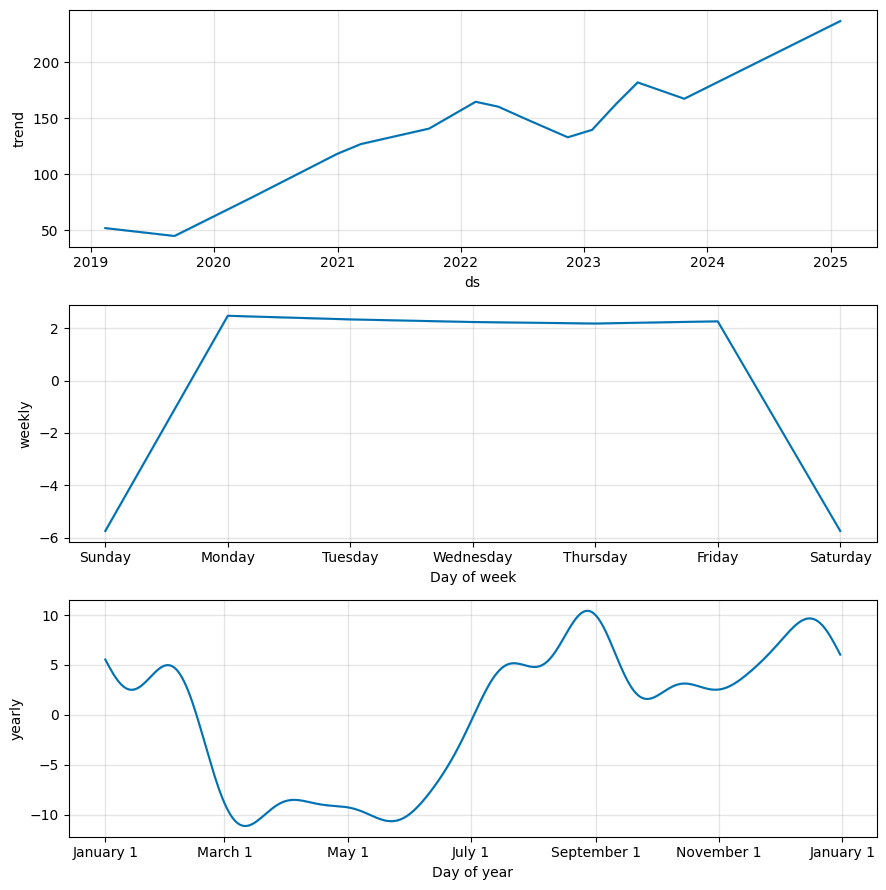

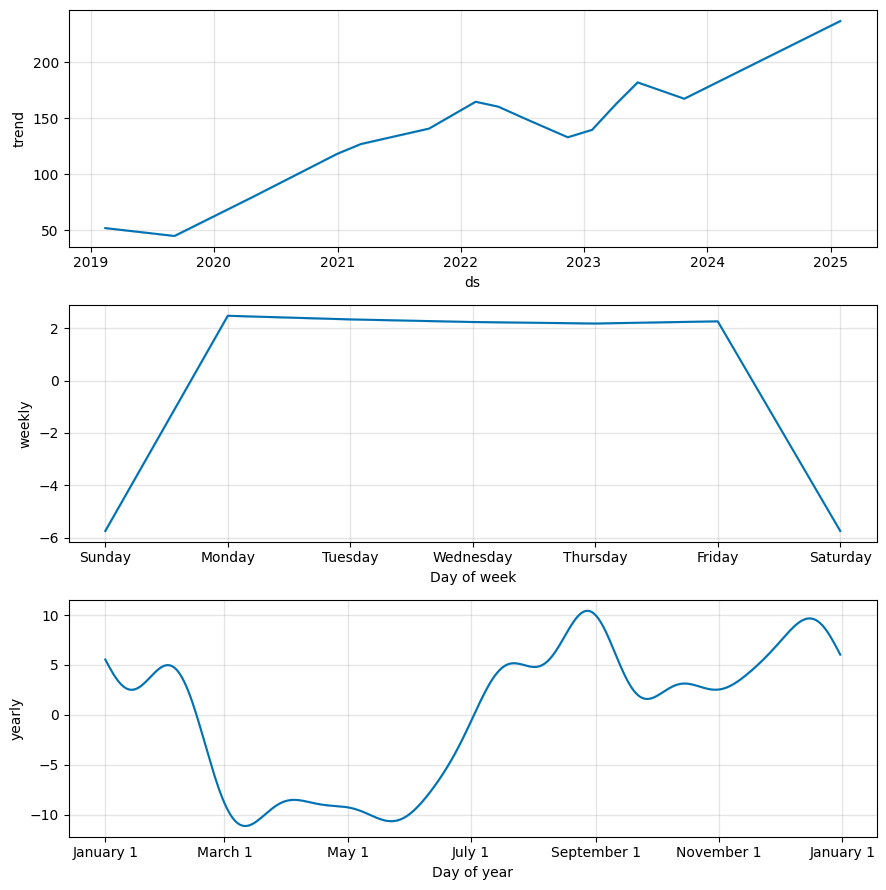

In [22]:
from prophet import Prophet
import pandas as pd

# Step 1: Create fresh DataFrame
df_prophet = pd.DataFrame()
df_prophet['ds'] = pd.to_datetime(data['Date'])
df_prophet['y'] = data['Close'].astype(float)  # Force y to be float

# Step 2: Drop any NA rows
df_prophet.dropna(inplace=True)

# Step 3: Fit the model
model = Prophet()
model.fit(df_prophet)

# Step 4: Forecast next 30 business days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Step 5: Plot the forecast
import matplotlib.pyplot as plt

model.plot(forecast)
plt.title('Facebook Prophet Forecast for AAPL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Optional: Plot trend + seasonality
model.plot_components(forecast)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [24]:
# Use just the 'Close' prices
lstm_data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(lstm_data)

# Create sequences for training (e.g., 60-day lookback)
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)


In [25]:
# Define model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile and train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0653
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8225e-04
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5341e-04
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3039e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

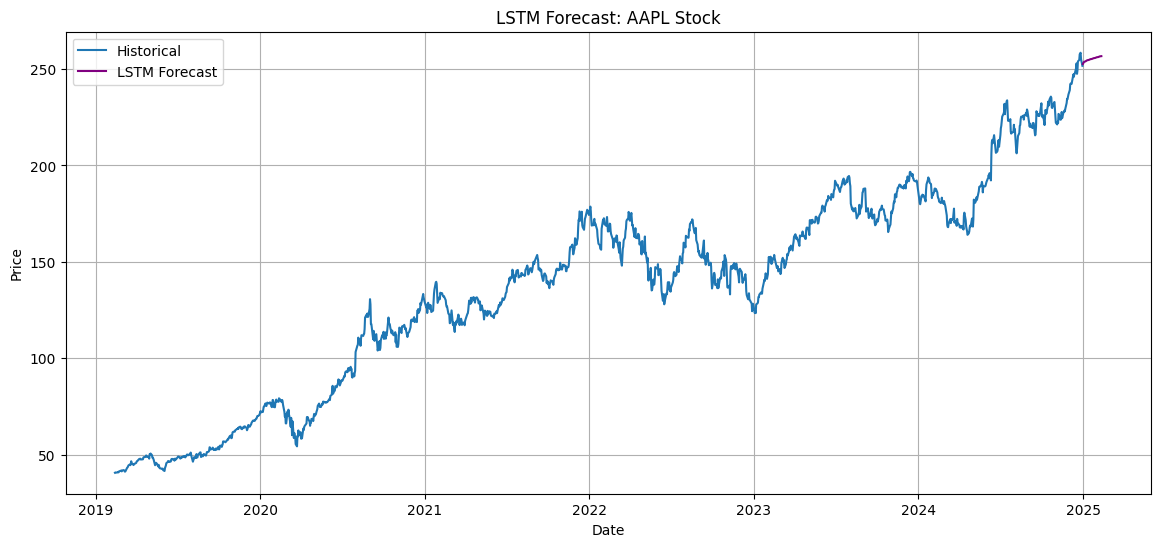

In [26]:
# Start with the last 60 days
last_60_days = scaled_data[-60:]
predicted = []

current_input = last_60_days.reshape(1, 60, 1)

for _ in range(30):
    pred = model.predict(current_input)[0][0]
    predicted.append(pred)

    # Update input
    current_input = np.append(current_input[:,1:,:], [[[pred]]], axis=1)

# Inverse scale back to real prices
predicted_prices = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))

# Plot
import matplotlib.pyplot as plt
future_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='B')

plt.figure(figsize=(14,6))
plt.plot(data['Date'], data['Close'], label='Historical')
plt.plot(future_dates, predicted_prices, label='LSTM Forecast', color='purple')
plt.title('LSTM Forecast: AAPL Stock')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
